# PART 2 - OPTIMIZATION

*Similar to the traveling sales man problem, we will assume this is a circular route. Each of the three ferries are to visit 12 stops[0-11] that will be randomly split into 3 groups of 4 stops.  The first departure port will be the origin port, followed by 3 other stops and finally back to origin, hence completing the circuit. A->B->C->D->A*

Given a 12x12 matrix there are 12! possible route combinations. We need a way to generate the route using a optimization technique using a Genetic Algorithm.

## Task 2.1 Generation of random solutions

- Load the data
- Import libraries
- Add headings
- Setup data frames
- Display the matrix

In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_colwidth', 100) # Sets max coloumn with for displaying dataframes

stops_cols = ["Longitude", "Latitude"]
stops = pd.read_csv('stops.csv',names=stops_cols)
distances_cols = ['stop0','stop1','stop2','stop3','stop4','stop5','stop6','stop7','stop8','stop9','stop10','stop11']
distances = pd.read_csv('distances.csv',names=distances_cols)
distance_matrix = distances.to_numpy()

display(stops,distances)

,Longitude,Latitude
0,6.084592,3.647243
1,3.757416,5.566100
2,4.804498,4.596598
3,4.703749,4.920296
4,-8.178210,-0.909409
5,-7.778165,-1.765424
6,-7.054886,-2.096278
7,-8.078685,-0.019262
8,0.319826,1.534481
9,1.489526,2.431312


,stop0,stop1,stop2,stop3,stop4,stop5,stop6,stop7,stop8,stop9,stop10,stop11
0,0.000000,3.016249,1.593711,1.878135,14.972996,14.881969,14.339942,14.630164,6.139730,4.753223,7.337186,9.437255
1,3.016249,0.000000,1.426995,1.145691,13.579080,13.668243,13.252092,13.087764,5.298205,3.869137,7.183670,8.523919
2,1.593711,1.426995,0.000000,0.339015,14.102015,14.099600,13.617620,13.685123,5.430363,3.959483,7.016806,8.761438
3,1.878135,1.145691,0.339015,0.000000,14.139672,14.159697,13.692984,13.703644,5.539180,4.065252,7.196627,8.859165
4,14.972996,13.579080,14.102015,14.139672,0.000000,0.944880,1.634171,0.895693,8.842467,10.228662,8.306492,5.681336
5,14.881969,13.668243,14.099600,14.159697,0.944880,0.000000,0.795359,1.771833,8.744531,10.173626,7.982827,5.470240
6,14.339942,13.252092,13.617620,13.692984,1.634171,0.795359,0.000000,2.315634,8.220024,9.669853,7.326569,4.902991
7,14.630164,13.087764,13.685123,13.703644,0.895693,1.771833,2.315634,0.000000,8.541025,9.877043,8.225050,5.536049
8,6.139730,5.298205,5.430363,5.539180,8.842467,8.744531,8.220024,8.541025,0.000000,1.473941,2.174070,3.334985
9,4.753223,3.869137,3.959483,4.065252,10.228662,10.173626,9.669853,9.877043,1.473941,0.000000,3.352873,4.801986


- Generate Random Solution

Following standard Object oriented principles our Generate class will have two methods. One to output a brand new solution and a Getter to get the current solution.

In [283]:
import random

class Generate():
    def __init__(self):
        self.num_vessels = 3
        self.stops_per_route = 4
        self.routes_np = None
        self.stops = stops
        self.stop_indices = list(range(0, len(stops)))
        

    def make_random_solution(self): # Generate initial solution
        random.shuffle(self.stop_indices)
        # divide the stops into sublists of length stops_per_route
        routes = np.array_split(self.stop_indices, self.num_vessels)
        self.routes_np = np.array(routes)
        return self.routes_np
    
    @property # Getter, no need to access like a method()
    def get_routes(self): # Can be called to obtain the current solution routes
        if self.routes_np is None:
            self.make_random_solution()
        return self.routes_np

generate = Generate() # Instantiate the Generate class


- Fitness function

*My Fitness function below returns a score by using the total distance traveled from the matrix  * standard deviation. This function will help to minimize both the total distance and the variability (standard deviation) of route lengths within the groups, hence allow us to evenly distribute route lengths amongst the groups.*

In [284]:

# Helper function to calculate the route distance of each stop for each route group
def calc_route_distance(choosen_route):
    total_distance = 0
    route_distance_matrix = []
    for i, stop in enumerate(choosen_route):
        if i < len(choosen_route) - 1:
            next_stop = choosen_route[i + 1]
            route_distance_matrix.append((distance_matrix[stop][next_stop]))
            total_distance += distance_matrix[stop][next_stop]
    # Return back to the origin stop (Circuit)
    total_distance += distance_matrix[choosen_route][-1][choosen_route][0]
    route_distance_matrix.append((distance_matrix[choosen_route][-1][choosen_route][0]))
    return total_distance,route_distance_matrix


 # Gets the fitness of a given route(s)
def get_fitness(routes):
    mean_distance = []
    route_distance = []
    
    for route in routes:
         #Returns the Route Distance(rd) for each group of 4, Returns Each Path Distance(epd)
         rd,epd = calc_route_distance(route)
         route_distance.append(rd)
         mean_distance.append(np.mean(epd))
    
    # Standard deviation - Shows the dispersement of distances, used to aid in fitness score

    std_dev = np.std(route_distance) # Less then 1.0 means the route lengths are more or less even.
    # fitness_score = (weight * np.sum(route_distance)) * std_dev
    fitness_score =  np.sum(route_distance) * std_dev
  
    return route_distance,mean_distance,fitness_score,std_dev


Call the fitness function to print out the results of a random route. This is the timetable we will submit to the fitness function.

In [289]:
# Get the random route, will not change until make_random_solution is called.

# random_route = generate.get_routes # Outputs a 2D array, each of the 3 index represents a route of 4 stops.

# Uncomment line below to start with a new random solution
random_route = generate.make_random_solution() 

print("Random 3 Route Generation \n", random_route) 

#Send the route to the fitness function
route_distance,mean_distance,fitness_score,std_dev = get_fitness(random_route)

print("3 Route Group Distances, including back to origin =" , route_distance)
print("Mean distances between each route stop per group=", mean_distance)
print("Fitness Score (Minimizing, Lower is better) - (np.sum(route_distance) * std_dev)) ="  , fitness_score)
print("Standard deviation - Shows the dispersement of distances, closer to 0 indicates a more even route", std_dev)
threshold = 1
if std_dev < threshold:
    print("\nThe mean distances are approximately even.")
else:
     print("\nThe mean distances are not even.")

Random 3 Route Generation 
 [[ 0 11  3  4]
 [ 9 10  1  5]
 [ 7  2  8  6]]
3 Route Group Distances, including back to origin = [47.40908870420877, 34.37841202668142, 29.65114327992252]
Mean distances between each route stop per group= [11.852272176052193, 8.594603006670354, 7.41278581998063]
Fitness Score (Minimizing, Lower is better) - (np.sum(route_distance) * std_dev)) = 836.8129784086697
Standard deviation - Shows the dispersement of distances, closer to 0 indicates a more even route 7.509181270435012

The mean distances are not even.


## Task 2.2 Algorithm Implementation

- Define mutation operators
- Set up hillclimber local search to incrementally find the best solution
- Print out 3 routes after 1 pass of the HillClimber with 30 iterations of mutation for each operator

Define mutation operators.
Create 3 Mutation operator's, Shuffle, Swap & Ruin-Recreate

In [290]:
import copy #For deep copy of multidimensional arrays

class Mutation_Operators():
    def __init__(self):
        pass
    
    def shuffle(self,solution): # Mutate a single group of 4 stops and shuffling their order
        child = copy.deepcopy(solution)
        random_group = np.random.randint(0,len(child))
        np.random.shuffle(child[random_group])
        return child
        
    
    def swap(self,solution): # Pick two random stops from any group and exchange their positions in the solution.
        child = copy.deepcopy(solution)
        idx1, idx2 = np.random.choice(len(stops), 2, replace=False)
        loc1 = np.argwhere(child == idx1).flatten()
        loc2 = np.argwhere(child == idx2).flatten()
        child[tuple(loc1)], child[tuple(loc2)] = child[tuple(loc2)],child[tuple(loc1)]
        return child
  
        
    def ruin_and_recreate(self,best_solution): # Creates a new random solution from scratch
        return generate.make_random_solution()
        

Hillclimber

In [291]:
import copy # For deep copying
pd.set_option('display.max_rows',5)

class HillClimber():
    def __init__(self):
        # Instantiate the class containing the operators
        self.mo = Mutation_Operators()
        
        # Generate initial random solution
        self.initial_random_solution = generate.make_random_solution()    
        self.best_solution = copy.deepcopy(self.initial_random_solution)
        self.route_distance,self.mean_distance,self.fitness_score,self.std_dev = get_fitness(self.best_solution)
        self.initial_fitness = np.sum(self.fitness_score)
        self.best_fitness = copy.deepcopy(self.initial_fitness)
        self.best_overall = []
        # self.fit = []
        
        # Define the operator list
        self.operator_list =  [
                                {"label" : "Swap", "operator" : self.mo.swap},
                                {"label" : "Shuffle", "operator" : self.mo.shuffle},
                                {"label" : "Ruin and Create", "operator" : self.mo.ruin_and_recreate},     
                        ]
       
      
        
    def runMutationOperators(self,operatorIterations):
        fit = []
        self.best_overall = []
        for operator in self.operator_list: 
            label = operator["label"]
            mutation_operator = operator["operator"] 
            fit.append((label,0,self.initial_random_solution,self.route_distance,self.std_dev,self.initial_fitness,self.best_fitness))
            for _ in range(operatorIterations):
                child_solution = mutation_operator(self.best_solution)
                route_distance,self.mean_distance,self.fitness_score,self.std_dev = get_fitness(child_solution)
                child_fitness = np.sum(self.fitness_score)
                                          
                if child_fitness < self.best_fitness:
                    # print("CHILD Won", child_fitness, "VS", self.best_fitness)
                    self.best_solution = copy.deepcopy(child_solution)
                    self.best_fitness = copy.deepcopy(child_fitness)
                # else:
                    # print("PARENT Won", self.best_fitness, "VS", child_fitness)
                fit.append((label,_,child_solution,route_distance,self.std_dev,child_fitness,self.best_fitness))
            calc_best = get_fitness(self.best_solution)
            self.best_overall.append((label,self.best_fitness,self.best_solution,calc_best[0],calc_best[3]))
            # Reset Solutions & Fitness for next operator to initial random values
            self.best_solution = copy.deepcopy(self.initial_random_solution)
            self.best_fitness = copy.deepcopy(self.initial_fitness)
        
        
        return fit,self.best_overall
            
    
    
    def runHillClimber(self,operatorIterations):
        columns=["Mutation", "Round #", "Solution","Route Distance", "Standard Dev", "Fitness score", "Best Fitness"]
        fit,best = self.runMutationOperators(operatorIterations)
        agg = pd.DataFrame(fit, columns=columns)
        agg = agg.groupby(["Mutation"])["Fitness score"].agg(["max", "min", "mean"]).reset_index().values.ravel()
        return fit,best,agg
       
    
    

    

What was the best solution and best score for each operator?

*Re-run this to view different results each time*

In [293]:
pd.set_option('display.max_rows', None)
hc = HillClimber()
operatorIterations = 30
fit,best_overall,_ = hc.runHillClimber(operatorIterations)
title = f"Best Overall for 1 runs and {operatorIterations} mutation runs each"
print(title)
print("-" * len(title))
best_overall_df = pd.DataFrame(best_overall,columns=["Mutation","Best Fitness Score", "Best Route Solution","Route Distance", "Std_dev"])
sorted = best_overall_df.sort_values(by='Best Fitness Score')
display(sorted)
print(f"{sorted.iloc[0]['Mutation']} was the best operator with a score of {sorted.iloc[0]['Best Fitness Score']}")

# Asserts (Unit Test) if the Standard Deviation is greater then 1.
# which indicates the multiple objectives were not met.
assert sorted.iloc[0]["Std_dev"] <= 1.00 


Best Overall for 1 runs and 30 mutation runs each
-------------------------------------------------


,Mutation,Best Fitness Score,Best Route Solution,Route Distance,Std_dev
0,Swap,21.105013,"[[3, 8, 4, 7], [0, 10, 11, 6], [9, 1, 2, 5]]","[28.980984429667267, 29.287439971437955, 29.569359209236822]",0.240273
1,Shuffle,61.533624,"[[10, 0, 8, 6], [4, 5, 2, 1], [7, 9, 3, 11]]","[29.023509667683335, 30.050554447295955, 28.33750822460224]",0.703953
2,Ruin and Create,88.935136,"[[9, 2, 10, 5], [1, 0, 7, 8], [3, 6, 4, 11]]","[29.132742242767037, 31.485643794997326, 29.867655755508117]",0.982860


Swap was the best operator with a score of 21.10501338068967


Plot of 1 run with 30 mutations. Plot shows each operator and their lowest (Best Fitness score)

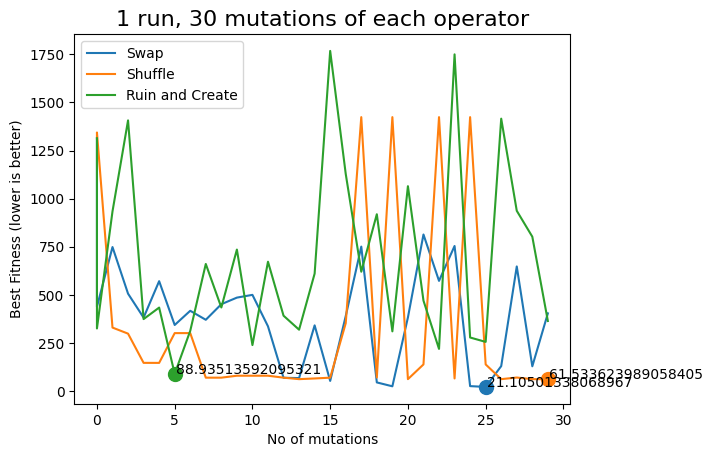

In [295]:
column_headings = ["Mutation", "Round #", "Solution","Route Distance" ,"Standard Dev", "Fitness score", "Best Fitness"]
dataframe = pd.DataFrame(fit,columns=column_headings)
operators = dataframe["Mutation"].unique()
for operator in operators:
    operator_data = dataframe[dataframe["Mutation"] == operator]
    plt.plot(operator_data["Round #"], operator_data["Fitness score"], label=operator)
    
    min_fitness_idx = operator_data["Fitness score"].idxmin()
    min_fitness_row = operator_data.loc[min_fitness_idx]
    
    plt.scatter(min_fitness_row["Round #"], min_fitness_row["Fitness score"], marker="o", s=100)
    plt.text(min_fitness_row["Round #"] + 0.1, min_fitness_row["Fitness score"], f"{min_fitness_row['Best Fitness']}")

plt.xlabel("No of mutations")
plt.ylabel("Best Fitness (lower is better)")
plt.title("1 run, 30 mutations of each operator", fontsize=16)
plt.legend()

Based on the Plot and the Dataframe above, I believe the optimizer is producing a sensible solution due to the decreasing nature of fitness score using the hilclimber elitist algorithm  It is possible that initial random mutations leave the mutations stuck in a local optima (shuffle in my recent testing), while others like the swap are able to find the global optima.

View all 90 mutations and their Score.
- 30 Rounds each excluding the initial random solution
- Showing the Fitness score of the child as well as the current best Fitness.
- This data will be used in the Visualization of results section

In [296]:
column_headings = ["Mutation", "Round #", "Solution","Route Distance","Standard Dev", "Fitness score", "Best Fitness"]
dataframe = pd.DataFrame(fit,columns=column_headings)
dataframe

,Mutation,Round #,Solution,Route Distance,Standard Dev,Fitness score,Best Fitness
0,Swap,0,"[[0, 8, 10, 6], [1, 5, 2, 4], [9, 11, 3, 7]]","[29.98031130183883, 55.44893769541059, 37.241838380423495]",10.712813,1314.152362,1314.152362
1,Swap,0,"[[0, 8, 10, 6], [1, 5, 11, 4], [9, 2, 3, 7]]","[29.98031130183883, 38.39889831268414, 27.879184165320737]",4.545471,437.539701,437.539701
2,Swap,1,"[[0, 11, 10, 6], [1, 5, 8, 4], [9, 2, 3, 7]]","[33.8110871445342, 44.834321177471764, 27.879184165320737]",7.025160,748.352285,437.539701
3,Swap,2,"[[0, 8, 1, 6], [10, 5, 11, 4], [9, 2, 3, 7]]","[39.029968908349446, 27.44089459510173, 27.879184165320737]",5.362822,505.982515,437.539701
4,Swap,3,"[[0, 8, 10, 5], [1, 6, 11, 4], [9, 2, 3, 7]]","[31.178596188907644, 37.41549770193736, 27.879184165320737]",3.954271,381.481491,381.481491
5,Swap,4,"[[9, 8, 10, 5], [1, 6, 11, 4], [0, 2, 3, 7]]","[21.804464736089564, 37.41549770193736, 30.266533317171238]",6.380688,570.985435,381.481491
6,Swap,5,"[[2, 8, 10, 5], [1, 6, 11, 4], [9, 0, 3, 7]]","[29.686859887518622, 37.41549770193736, 30.212044498328993]",3.526052,343.135665,343.135665
7,Swap,6,"[[2, 8, 3, 5], [1, 6, 11, 4], [9, 0, 10, 7]]","[39.22883951194062, 37.41549770193736, 30.192501261012318]",3.903208,417.006404,343.135665
8,Swap,7,"[[2, 8, 10, 5], [1, 7, 11, 4], [9, 0, 3, 6]]","[29.686859887518622, 37.88422808236899, 29.994194338797]",3.793912,370.154121,343.135665
9,Swap,8,"[[2, 8, 10, 1], [5, 6, 11, 4], [9, 0, 3, 7]]","[16.215098059935684, 12.324565353346811, 30.212044498328993]",7.681237,451.285813,343.135665


## Task 2.3 Visualisation of results

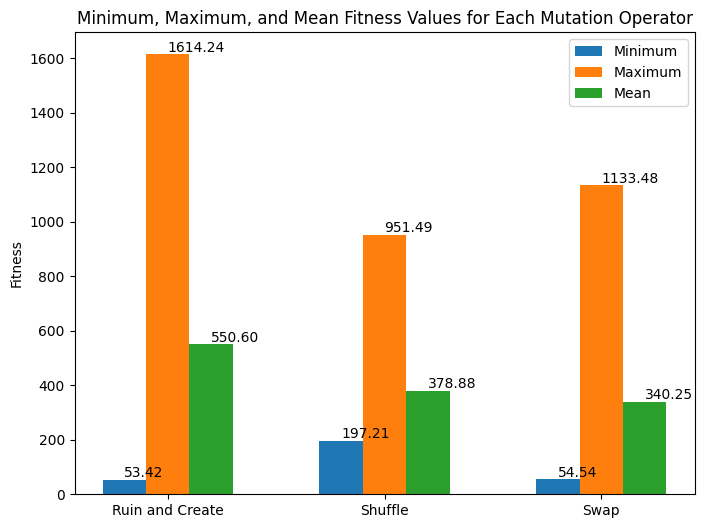

In [299]:
pd.set_option('display.max_rows', None)
operatorIterations = 30 # 30 mutation iterations for each operator
algoIterations = 500 # Repeat 500 times
arr = []
for i in range(algoIterations): 
    hc = HillClimber()
    _,_,agg = hc.runHillClimber(operatorIterations)
    arr.append(agg)
arr = np.array(arr)
    

operators = arr[0, np.arange(0, arr.shape[1], 4)]

# get the minimum, maximum, and mean values for each operator
min_values = arr[:, np.arange(2, arr.shape[1], 4)].astype(float)
max_values = arr[:, np.arange(1, arr.shape[1], 4)].astype(float)
mean_values = arr[:, np.arange(3, arr.shape[1], 4)].astype(float)

# create a grouped bar plot of the minimum, maximum, and mean values for each operator
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.2
x = np.arange(len(operators))
ax.bar(x-bar_width, min_values.mean(axis=0), width=bar_width, label='Minimum')
ax.bar(x, max_values.mean(axis=0), width=bar_width, label='Maximum')
ax.bar(x+bar_width, mean_values.mean(axis=0), width=bar_width, label='Mean')
ax.set_xticks(x)
ax.set_xticklabels(operators)

ax.set_ylabel('Fitness')
ax.legend()
ax.set_title('Minimum, Maximum, and Mean Fitness Values for Each Mutation Operator')
# add text labels to the bars
for i, val in enumerate(min_values.mean(axis=0)):
    ax.text(i-bar_width, val+10, '{:.2f}'.format(val))
for i, val in enumerate(max_values.mean(axis=0)):
    ax.text(i, val+10, '{:.2f}'.format(val))
for i, val in enumerate(mean_values.mean(axis=0)):
    ax.text(i+bar_width, val+10, '{:.2f}'.format(val))
plt.show()

Plot results over single in

- APPROXIMATE THE GREATER FRONT
- MULTI OBJECTIVE OPTIMIZATION
  - Routes of even length
  - Minimize distance traveled
  - Dominance ( Have we made any of the objectives worse, have we improved them)
  - Optimal set is the greater front.
  - 